In [10]:
#Graphs with NetworkX

In [11]:
import networkx as nx
H = nx.DiGraph()

In [12]:
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])

In [13]:
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)


])

In [14]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

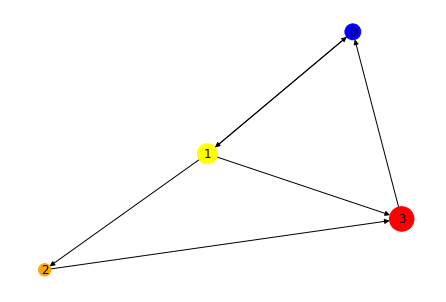

In [15]:
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

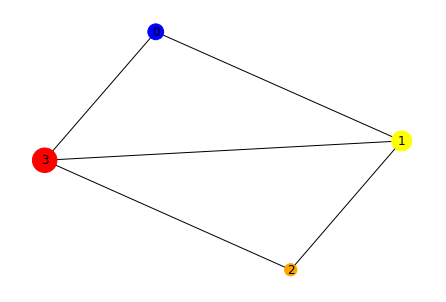

In [16]:
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [17]:
# Building a Graph Neural Network with Pytorch

In [18]:
!pip install -q torch

In [19]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [20]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [21]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


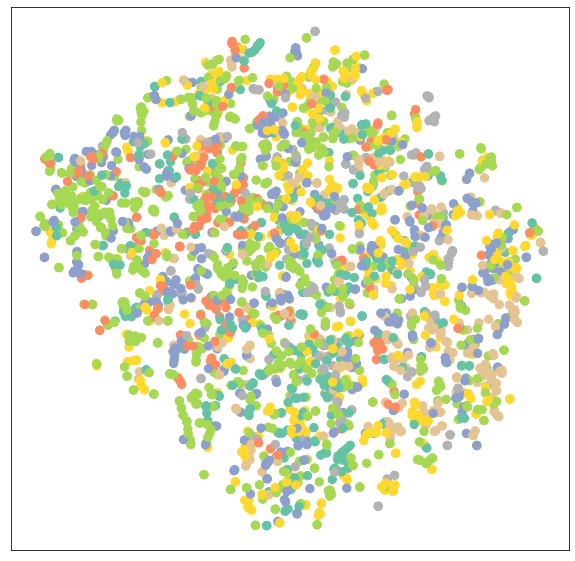

In [23]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [24]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [25]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8150


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


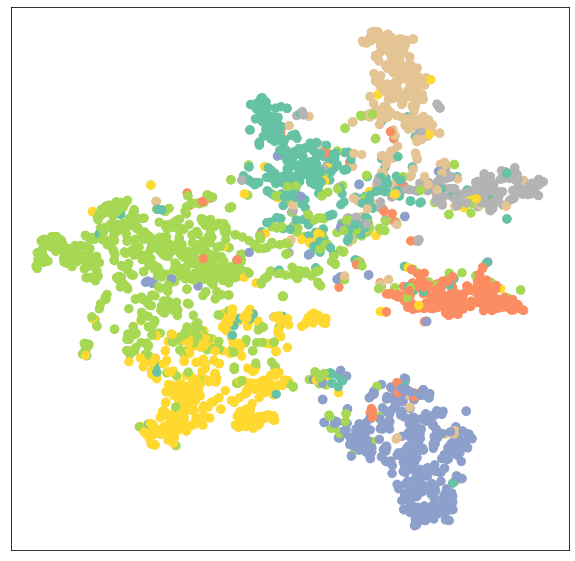

In [26]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [27]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')



GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1540, Test: 0.1660
Epoch: 002, Loss: 3.9907, Val: 0.1240, Test: 0.1310
Epoch: 003, Loss: 3.9534, Val: 0.0960, Test: 0.1100
Epoch: 004, Loss: 3.9121, Val: 0.0860, Test: 0.1020
Epoch: 005, Loss: 3.8659, Val: 0.0840, Test: 0.0920
Epoch: 006, Loss: 3.8015, Val: 0.0780, Test: 0.0890
Epoch: 007, Loss: 3.7434, Val: 0.0680, Test: 0.0800
Epoch: 008, Loss: 3.6690, Val: 0.0660, Test: 0.0760
Epoch: 009, Loss: 3.6004, Val: 0.0640, Test: 0.0740
Epoch: 010, Loss: 3.5158, Val: 0.0640, Test: 0.0720
Epoch: 011, Loss: 3.4187, Val: 0.0620, Test: 0.0710
Epoch: 012, Loss: 3.3205, Val: 0.0600, Test: 0.0690
Epoch: 013, Loss: 3.2355, Val: 0.0580, Test: 0.0670
Epoch: 014, Loss: 3.1221, Val: 0.0580, Test: 0.0670
Epoch: 015, Loss: 2.9988, Val: 0.0580, Test: 0.0670
Epoch: 016, Loss: 2.8735, Val: 0.0580, Test: 0.0660
Epoch: 017, Loss: 2.7678, Val: 0.0580, Test: 0.0660
Epoch: 018, Loss: 2.6441, Val: 0.0580

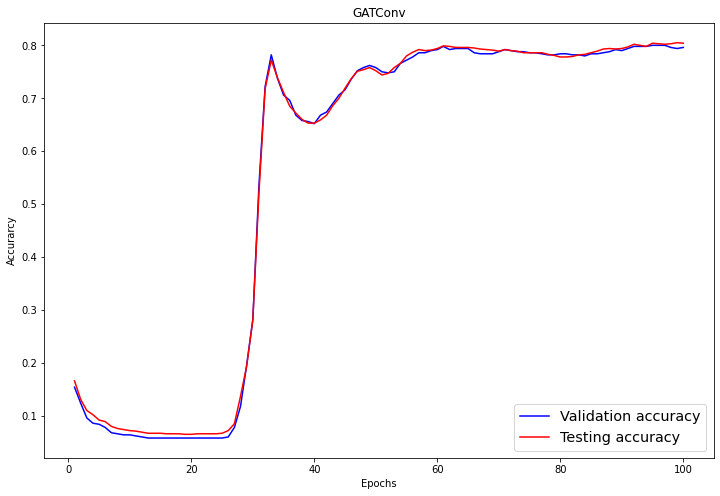

In [28]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


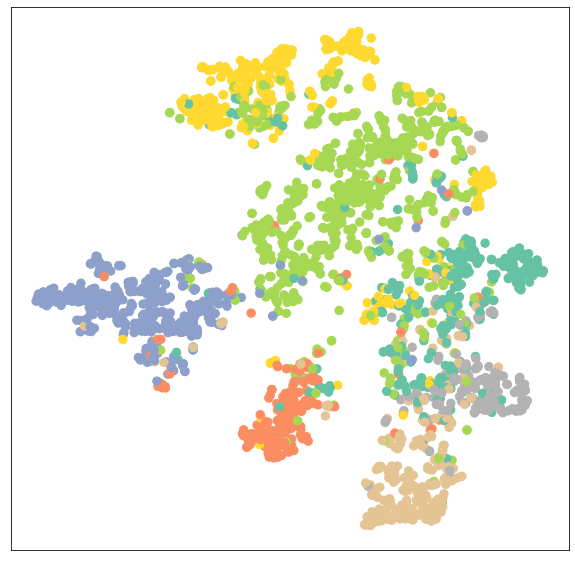

In [29]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)